# About
- Explore using Langchain to create a QA dataset
- helpful resource: https://huggingface.co/learn/cookbook/en/rag_evaluation

# Imports and Settings

In [80]:
import pandas as pd
import numpy as np
import os
from langchain_openai import ChatOpenAI
from langchain.prompts.chat import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.schema import HumanMessage, SystemMessage
from langchain.output_parsers import PydanticOutputParser
from langchain.globals import set_debug, set_verbose
from langchain.callbacks import get_openai_callback
from pydantic import BaseModel, Field, validator
from typing import List
from langchain.chains import LLMChain

from dotenv import load_dotenv


In [141]:
pd.set_option('display.max_colwidth', None)  # Or use a large number if 'None' does not work in some environments
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all row

In [4]:
set_debug(True)
load_dotenv()
OPENAI_APIKEY = os.environ['OPENAI_APIKEY']

In [ ]:
# See how many tokens there are across the dataset
# Use Gemini playgroud to try to  generate some questions and answers
# Try using gpt as well
# Maybe try using GPT with a higher temperature to get some variety of questions
# Ask for the names of the source documents
# Try using factoid in the prompt to see if that makes a difference
# Try asking for questions from different perspectives?
# How large should the dataset be?
# should I use a verification LLM to check all of it too?

# Load Data

In [8]:
df = pd.read_csv('../data/transcripts_all_2024-04-10_cleaned')
df.head()

,Unnamed: 0.1,Unnamed: 0,videoId,title,description,publishedAt,date,year,transcript
0,0,0,r3PuCQ8CxTc,Benefits and Side Effects of the Pneumonia Vac...,Randomized controlled trials have found that p...,2024-04-10T11:59:52Z,2024-04-10,2024,"""Benefits and Side Effects of the Pneumonia Va..."
1,2,2,oa6UtySJKFE,Benefits and Side Effects of the Flu Vaccine,Flu shots can prevent more than just the flu. ...,2024-04-08T11:59:55Z,2024-04-08,2024,"In this 3-video series, I show the science beh..."
2,3,3,wZLgy4dvM1Y,New Sponsorship: Big Broccoli,Help keep us ad- and sponsorship-free by makin...,2024-04-07T15:59:56Z,2024-04-07,2024,I’m Dr. Michael Greger and ever since I starte...
3,4,4,Et0lozAIbI8,Friday Favorites: Removing Warts with Duct Tape,Duct tape beat out cryotherapy (freezing) and ...,2024-04-05T11:59:52Z,2024-04-05,2024,You can find home remedies for all sorts of ai...
4,5,5,EoAaCdlK6CU,Podcast: Hot Flashes,Turns out that hot flashes are not inevitable....,2024-04-04T12:59:57Z,2024-04-04,2024,I hear from lots of people every day who are c...


# Get Token Counts

In [14]:
#instantiate the cat model
chat_model = ChatOpenAI(api_key=OPENAI_APIKEY, temperature=0.8, model='gpt-4-turbo-2024-04-09')

In [16]:
#Count number of tokens
df['num_tokens'] = df['transcript'].apply(chat_model.get_num_tokens)

In [25]:
num_tokens = df['num_tokens'].sum()
print(f"Total number of transcript tokens: {num_tokens}")
print("Cost transcript input on gpt4 turbo", num_tokens / 1000000 *10)
print("Cost transcript input on gpt3.5", num_tokens/1000000 * 0.5)

Total number of transcript tokens: 2870591
Cost transcript input on gpt4 turbo 28.705910000000003
Cost transcript input on gpt3.5 1.4352955


In [26]:
df[df['year']>=2020]['num_tokens'].sum()

1530117

<Axes: >

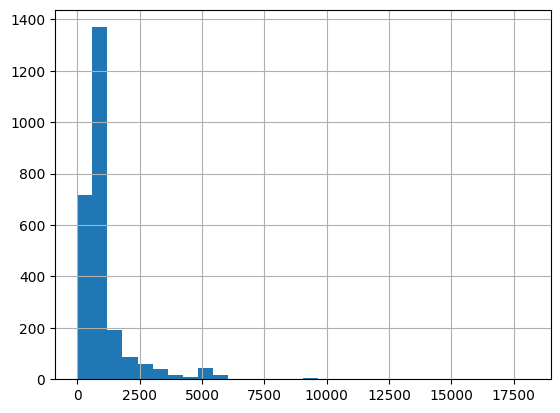

In [30]:
# Whats the distribution of token sizes
df['num_tokens'].hist(bins=30)

In [29]:
df['num_tokens'].describe()

count     2569.000000
mean      1117.396263
std       1309.664550
min          4.000000
25%        569.000000
50%        855.000000
75%       1099.000000
max      18087.000000
Name: num_tokens, dtype: float64

In [35]:
df['num_tokens'].sort_values().head(100)

315       4
125       4
320       4
421       4
331       4
       ... 
21      129
826     130
2180    130
110     131
205     132
Name: num_tokens, Length: 100, dtype: int64

In [36]:
df.loc[205, "transcript"]

"are frozen greens like countless finish as nutritious and fresh as fresh in fact sometimes can be more nutritious because they were actually Frozen the day of picking as opposed to you know wilting for a week on the shelf and then in your crisper a losing Nutri being exposed to uh and uh and losing nutrition every day so and look Frozen greens pre-chopped pre-washed um uh you know basically lasts forever in the freezer so you don't have to keep going getting greens every day um or instacarting them uh and so you look at my freezer it's half frozen berries have Frozen greens um and so I'm a huge fan and I say go for it"

In [37]:
df.loc[205, :]

Unnamed: 0.1                                                  218
Unnamed: 0                                                    218
videoId                                               Qy09qg0iFx0
title            Q&A: Are frozen vegetables as healthy as frozen?
description     Note: If you’re eating cups a day (as everyone...
publishedAt                                  2023-07-13T20:00:07Z
date                                                   2023-07-13
year                                                         2023
transcript      are frozen greens like countless finish as nut...
num_tokens                                                    132
Name: 205, dtype: object

In [38]:
df[df['num_tokens']==18087]

,Unnamed: 0.1,Unnamed: 0,videoId,title,description,publishedAt,date,year,transcript,num_tokens
78,80,80,0nrVrh97dg8,Preventing and Treating Osteoporosis (Webinar ...,I’m happy to share the recording of my webinar...,2024-01-01T12:59:53Z,2024-01-01,2024,a few months ago I presented a webinar on oste...,18087


There are some very short videos and some long ones. I think rather than over thinking it, I am just going to take a random sample across the whole dataset for prompt engineering

# Create a sample for prompt engineering

In [108]:
# Random sample
df_sample = df.sample(5)
# Create a small sample on a specific topic
df_topic = df[df['title'].str.contains("Diverticulosis", case=False)]
# Add all documents on diverticulosis
df_sample = pd.concat([df_sample, df_topic])
# View sample
df_sample

,Unnamed: 0.1,Unnamed: 0,videoId,title,description,publishedAt,date,year,transcript,num_tokens
236,252,252,zMhkwFnoqnc,Friday Favorites: Cut the Calorie-Rich-And-Pro...,We have an uncanny ability to pick out the sub...,2023-06-02T11:59:48Z,2023-06-02,2023,[Music] foreign [Music] the traditional medica...,953
2207,2234,2234,c7DZ4OFxONc,Engineering a Cure,New subscribers to our e-newsletter always rec...,2012-09-17T10:35:38Z,2012-09-17,2012,"""Engineering a Cure"" Before Esselstyn, before ...",269
281,298,298,EvcYy8_bCx0,Soul Food That’s Good for the Soul,The best of soul food’s origins are tied to th...,2023-03-27T11:59:47Z,2023-03-27,2023,"""Soul Food That’s Good for the Soul"" The burde...",1101
2371,2398,2398,Ka_ngjez9dA,Atkins Diet: Trouble Keeping it Up,New subscribers to our e-newsletter always rec...,2012-01-24T22:02:35Z,2012-01-24,2012,“Atkins Diet: Trouble Keeping It Up” Remember ...,511
881,904,904,Vlr7aXD5hqI,How to Test for Functional Vitamin B12 Deficiency,Many doctors mistakenly rely on serum B12 leve...,2020-08-31T11:59:46Z,2020-08-31,2020,"""How to Test for Functional Vitamin B12 Defici...",818
1728,1753,1753,5A0ChIZsdHY,Does Fiber Really Prevent Diverticulosis?,The parable of the tiny parachute explains the...,2015-07-20T11:25:52Z,2015-07-20,2015,"""Does Fiber Really Prevent Diverticulosis?"" A ...",825
1729,1754,1754,K64v_V2Z3QE,Diverticulosis: When Our Most Common Gut Disor...,More than two-thirds of Americans over age 60 ...,2015-07-17T11:09:34Z,2015-07-17,2015,"""Diverticulosis: When Our Most Common Gut Diso...",655
2517,2544,2544,kYMbK4pMYNo,Diverticulosis & Nuts,New subscribers to our e-newsletter always rec...,2011-03-09T03:32:09Z,2011-03-09,2011,"""Diverticulosis & Nuts"" Still, nuts are the be...",467


In [57]:
df_topic

,Unnamed: 0.1,Unnamed: 0,videoId,title,description,publishedAt,date,year,transcript,num_tokens
1728,1753,1753,5A0ChIZsdHY,Does Fiber Really Prevent Diverticulosis?,The parable of the tiny parachute explains the...,2015-07-20T11:25:52Z,2015-07-20,2015,"""Does Fiber Really Prevent Diverticulosis?"" A ...",825
1729,1754,1754,K64v_V2Z3QE,Diverticulosis: When Our Most Common Gut Disor...,More than two-thirds of Americans over age 60 ...,2015-07-17T11:09:34Z,2015-07-17,2015,"""Diverticulosis: When Our Most Common Gut Diso...",655
2517,2544,2544,kYMbK4pMYNo,Diverticulosis & Nuts,New subscribers to our e-newsletter always rec...,2011-03-09T03:32:09Z,2011-03-09,2011,"""Diverticulosis & Nuts"" Still, nuts are the be...",467


In [109]:
# Function to format the row
def format_row(row):
    return f"videoID: {row['videoId']} \n Transcript: {row['transcript']}"

df_sample['formatted_transcript'] = df_sample[['videoId', 'transcript']].apply(format_row, axis=1)

df_sample

,Unnamed: 0.1,Unnamed: 0,videoId,title,description,publishedAt,date,year,transcript,num_tokens,formatted_transcript
236,252,252,zMhkwFnoqnc,Friday Favorites: Cut the Calorie-Rich-And-Pro...,We have an uncanny ability to pick out the sub...,2023-06-02T11:59:48Z,2023-06-02,2023,[Music] foreign [Music] the traditional medica...,953,videoID: zMhkwFnoqnc \n Transcript: [Music] fo...
2207,2234,2234,c7DZ4OFxONc,Engineering a Cure,New subscribers to our e-newsletter always rec...,2012-09-17T10:35:38Z,2012-09-17,2012,"""Engineering a Cure"" Before Esselstyn, before ...",269,"videoID: c7DZ4OFxONc \n Transcript: ""Engineeri..."
281,298,298,EvcYy8_bCx0,Soul Food That’s Good for the Soul,The best of soul food’s origins are tied to th...,2023-03-27T11:59:47Z,2023-03-27,2023,"""Soul Food That’s Good for the Soul"" The burde...",1101,"videoID: EvcYy8_bCx0 \n Transcript: ""Soul Food..."
2371,2398,2398,Ka_ngjez9dA,Atkins Diet: Trouble Keeping it Up,New subscribers to our e-newsletter always rec...,2012-01-24T22:02:35Z,2012-01-24,2012,“Atkins Diet: Trouble Keeping It Up” Remember ...,511,videoID: Ka_ngjez9dA \n Transcript: “Atkins Di...
881,904,904,Vlr7aXD5hqI,How to Test for Functional Vitamin B12 Deficiency,Many doctors mistakenly rely on serum B12 leve...,2020-08-31T11:59:46Z,2020-08-31,2020,"""How to Test for Functional Vitamin B12 Defici...",818,"videoID: Vlr7aXD5hqI \n Transcript: ""How to Te..."
1728,1753,1753,5A0ChIZsdHY,Does Fiber Really Prevent Diverticulosis?,The parable of the tiny parachute explains the...,2015-07-20T11:25:52Z,2015-07-20,2015,"""Does Fiber Really Prevent Diverticulosis?"" A ...",825,"videoID: 5A0ChIZsdHY \n Transcript: ""Does Fibe..."
1729,1754,1754,K64v_V2Z3QE,Diverticulosis: When Our Most Common Gut Disor...,More than two-thirds of Americans over age 60 ...,2015-07-17T11:09:34Z,2015-07-17,2015,"""Diverticulosis: When Our Most Common Gut Diso...",655,"videoID: K64v_V2Z3QE \n Transcript: ""Diverticu..."
2517,2544,2544,kYMbK4pMYNo,Diverticulosis & Nuts,New subscribers to our e-newsletter always rec...,2011-03-09T03:32:09Z,2011-03-09,2011,"""Diverticulosis & Nuts"" Still, nuts are the be...",467,"videoID: kYMbK4pMYNo \n Transcript: ""Diverticu..."


In [110]:
# Create string
transcript_string = '\n\n'.join(df_sample['formatted_transcript'])
transcript_string

'videoID: zMhkwFnoqnc \n Transcript: [Music] foreign [Music] the traditional medical view on Obesity is summed up nearly a century ago all obese persons are alike in one fundamental respect they literally overeat well this may be true in a technical sense this is in reference to overeating calories not food our primitive urge to overindulge is selective people don\'t tend to lust for lettuce we have a natural inborn preference for sweet starchy fatty foods because that\'s where the calories are concentrated think about hunting and Gathering efficiency uh we used to have to work hard for our food prehistorically it doesn\'t make sense to spend all day collecting types of food that on average don\'t provide at least a day\'s worth of calories right you would have been better off staying back in the cave right so we evolved to Crave foods with the biggest caloric bang for their buck if we were able to steadily Forge a pound of food an hour and it had 250 calories per pound it might take y

In [111]:
# Number of tokesn from the transcripts
chat_model.get_num_tokens(transcript_string)

5715

# Setup the Prompt

In [126]:
# Create the output parser
class SupportingEvidence(BaseModel):
    videoId: str
    supporting_text: str

class QAItem(BaseModel):
    question: str
    answer: str
    supporting_evidence: List[SupportingEvidence]

class QAList(BaseModel):
    items: List[QAItem]

parser = PydanticOutputParser(pydantic_object=QAList)
format_instructions = parser.get_format_instructions()
print(format_instructions)

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"$defs": {"QAItem": {"properties": {"question": {"title": "Question", "type": "string"}, "answer": {"title": "Answer", "type": "string"}, "supporting_evidence": {"items": {"$ref": "#/$defs/SupportingEvidence"}, "title": "Supporting Evidence", "type": "array"}}, "required": ["question", "answer", "supporting_evidence"], "title": "QAItem", "type": "object"}, "SupportingEvidence": {"properties": {"videoId": {"title": "Videoid", "type": "string"}, "supporting_text": {"title": "Supporting Text", "type": "string"}}, "required": ["videoId", "support

In [127]:
SYSTEM_PROMPT = "You are looking for information across a wide range of topics on plant-based nutrition and health."
QA_PROMPT = '''These are transcripts of videos made by a Dr Micheal McGregor for a website called Nutrition Facts. Each transcript begins with the date, and video id followed by the transcript itself. 
{transcripts}
Given the transcripts above, create {num_questions} questions that could be answered by one or more of the transcripts. 
Your question should be formulated in the same style as questions users could ask in a search engine.
Your answer should be concise and factual based solely on the content of the transcripts. 
At least 30 percent of the questions require more than one transcript to asnwer. Make sure each transcript has at least one associated question and answer pair.
Return the question, the supporting pieces of text from the transcripts verbatim that would answer the question in a list format (each piece of text is a new entry in the list), the answer,  and document IDs required to answer the question. 
The answer should be a valid JSON object. 
{format_instructions}
'''
system_message_prompt = SystemMessagePromptTemplate.from_template(SYSTEM_PROMPT)
qa_message_prompt = HumanMessagePromptTemplate.from_template(QA_PROMPT)
chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, qa_message_prompt])



In [128]:
chain = LLMChain(prompt=chat_prompt, llm=chat_model)
# chain = chat_prompt | chat_model | parser

In [129]:
result = chain.invoke({'transcripts': transcript_string, 'num_questions': 5, 'format_instructions': format_instructions}, return_exceptions=True)

In [130]:
result['text']

'```json\n{\n  "items": [\n    {\n      "question": "How does calorie density influence food preferences according to Dr. Michael McGregor?",\n      "answer": "People have evolved to prefer foods that provide the biggest caloric bang for their buck due to primitive urges and the efficiency of hunting and gathering. Foods with higher calorie densities are more desirable because they are more efficient in terms of foraging time and energy expenditure.",\n      "supporting_evidence": [\n        {\n          "videoId": "zMhkwFnoqnc",\n          "supporting_text": "the greater the energy density the more calories per pound the more efficient the foraging so we developed an acute ability to discriminate Foods based on calorie density and to instinctively desire the densest"\n        }\n      ]\n    },\n    {\n      "question": "What diet did Nathan Pritikin follow to reverse his heart disease and what were his autopsy findings?",\n      "answer": "Nathan Pritikin followed a plant-based diet,

In [134]:
result_parsed = parser.parse(result['text'])

In [138]:
result_parsed

QAList(items=[QAItem(question='How does calorie density influence food preferences according to Dr. Michael McGregor?', answer='People have evolved to prefer foods that provide the biggest caloric bang for their buck due to primitive urges and the efficiency of hunting and gathering. Foods with higher calorie densities are more desirable because they are more efficient in terms of foraging time and energy expenditure.', supporting_evidence=[SupportingEvidence(videoId='zMhkwFnoqnc', supporting_text='the greater the energy density the more calories per pound the more efficient the foraging so we developed an acute ability to discriminate Foods based on calorie density and to instinctively desire the densest')]), QAItem(question='What diet did Nathan Pritikin follow to reverse his heart disease and what were his autopsy findings?', answer='Nathan Pritikin followed a plant-based diet, which significantly lowered his cholesterol from 280 to 94, effectively reversing his heart disease. His a

In [139]:
def flatten_data(qa_list):
    flat_list = []
    for item in qa_list.items:
        for evidence in item.supporting_evidence:
            flat_list.append({
                "question": item.question,
                "answer": item.answer,
                "videoId": evidence.videoId,
                "supporting_text": evidence.supporting_text
            })
    return flat_list

# Convert the flattened list to a DataFrame
data = flatten_data(result_parsed)
df = pd.DataFrame(data)

In [142]:
df

,question,answer,videoId,supporting_text
0,How does calorie density influence food preferences according to Dr. Michael McGregor?,People have evolved to prefer foods that provide the biggest caloric bang for their buck due to primitive urges and the efficiency of hunting and gathering. Foods with higher calorie densities are more desirable because they are more efficient in terms of foraging time and energy expenditure.,zMhkwFnoqnc,the greater the energy density the more calories per pound the more efficient the foraging so we developed an acute ability to discriminate Foods based on calorie density and to instinctively desire the densest
1,What diet did Nathan Pritikin follow to reverse his heart disease and what were his autopsy findings?,"Nathan Pritikin followed a plant-based diet, which significantly lowered his cholesterol from 280 to 94, effectively reversing his heart disease. His autopsy showed that his coronary arteries were soft, pliable, and widely patent, with an almost complete absence of atherosclerosis.",c7DZ4OFxONc,"he wasn't satisfied with the medical profession's fatalism...and finally arrived at a plant-based diet, dropping his cholesterol from 280 down to 94, reversing his own heart disease."
2,What diet did Nathan Pritikin follow to reverse his heart disease and what were his autopsy findings?,"Nathan Pritikin followed a plant-based diet, which significantly lowered his cholesterol from 280 to 94, effectively reversing his heart disease. His autopsy showed that his coronary arteries were soft, pliable, and widely patent, with an almost complete absence of atherosclerosis.",c7DZ4OFxONc,"his coronary arteries were found to be soft and pliable, and widely patent throughout."
3,What factors contribute to cardiovascular disease disparities in the African American community and how are plant-based diets being utilized?,"Factors contributing to cardiovascular disease disparities include high blood pressure, diabetes, obesity, and high cholesterol, which are prevalent due to poor dietary habits linked to 'soul food'. Increasingly, African Americans are adopting plant-based diets, and the emergence of vegan soul food restaurants helps promote healthier eating habits within the community.",EvcYy8_bCx0,The burden of cardiovascular disease in the African American community remains high and is a primary cause of disparities in life expectancy between African Americans and whites...Much can be traced back to diet.
4,What factors contribute to cardiovascular disease disparities in the African American community and how are plant-based diets being utilized?,"Factors contributing to cardiovascular disease disparities include high blood pressure, diabetes, obesity, and high cholesterol, which are prevalent due to poor dietary habits linked to 'soul food'. Increasingly, African Americans are adopting plant-based diets, and the emergence of vegan soul food restaurants helps promote healthier eating habits within the community.",EvcYy8_bCx0,"more and more African Americans are adopting plant-based diets to combat their health problems, helped by a growing movement of vegan soul food restaurants that serve healthier, plant-based meals."
5,What are the risks of a low-carb diet like the Atkins Diet based on a case report?,"A low-carb diet like the Atkins Diet can lead to increased cholesterol levels, erectile dysfunction, chest pains, and severe cardiovascular issues such as a 99% blockage in coronary arteries, as evidenced by a case report of a 51-year-old man.",Ka_ngjez9dA,He got a cardiac catheterization which found a 99% blockage of one of his coronary arteries supplying blood to his heart.
6,What are the risks of a low-carb diet like the Atkins Diet based on a case report?,"A low-carb diet like the Atkins Diet can lead to increased cholesterol levels, erectile dysfunction, chest pains, and severe cardiovascular issues such as a 99% blockage in coronary arteries, as evidenced by a case report of a 51-year-old man.",Ka_ngjez9

# Just try getting the questions

In [143]:
# Create the output parser
# class SupportingEvidence(BaseModel):
#     videoId: str
#     # supporting_text: str

class QAItem(BaseModel):
    question: str
    # answer: str
    videoIds: List

class QAList(BaseModel):
    items: List[QAItem]

parser = PydanticOutputParser(pydantic_object=QAList)
format_instructions = parser.get_format_instructions()
print(format_instructions)

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"$defs": {"QAItem": {"properties": {"question": {"title": "Question", "type": "string"}, "transcripts": {"items": {}, "title": "Transcripts", "type": "array"}}, "required": ["question", "transcripts"], "title": "QAItem", "type": "object"}}, "properties": {"items": {"items": {"$ref": "#/$defs/QAItem"}, "title": "Items", "type": "array"}}, "required": ["items"]}
```


In [144]:
SYSTEM_PROMPT = "You are an expert at generating short questions in the style of a quick google search."
QA_PROMPT = '''The following are transcripts of videos on plant-based nutrition. Each transcript begins with the date, video titlae, and video id followed by the transcript itself. 
{transcripts}
Given the transcripts above, create {num_questions} questions that could be answered by one or more of the transcripts. 
Your questions should be formulated in the same style as questions users could ask in a search engine.
Examples:
"best foods for diverticulosis"
"low carb diets safety"
"fiber sources for diverticulosis"

At least 30 percent of the questions require more than one transcript to asnwer. Make sure each transcript has at least one associated question and answer pair. 
Return the question and the videoIds corresponding to the transcripts that would contain the answers. 

{format_instructions}
'''
system_message_prompt = SystemMessagePromptTemplate.from_template(SYSTEM_PROMPT)
qa_message_prompt = HumanMessagePromptTemplate.from_template(QA_PROMPT)
chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, qa_message_prompt])

In [145]:
chain = chat_prompt | chat_model | parser

In [147]:
result = chain.invoke({'transcripts': transcript_string, 'num_questions': 20, 'format_instructions': format_instructions })

In [153]:
data = [{'question': item.question, 'transcript_ids': item.transcripts} for item in result.items]
df = pd.DataFrame(data)

In [154]:
df

,question,transcript_ids
0,impact of plant-based diets on obesity,[zMhkwFnoqnc]
1,history of Nathan Pritikin's diet research,[c7DZ4OFxONc]
2,health disparities in African American diet,[EvcYy8_bCx0]
3,risks associated with Atkins Diet,[Ka_ngjez9dA]
4,how to test for vitamin B12 deficiency,[Vlr7aXD5hqI]
5,role of fiber in preventing diverticulosis,"[5A0ChIZsdHY, K64v_V2Z3QE]"
6,misconceptions about nuts and diverticulosis,[kYMbK4pMYNo]
7,relationship between plant-based diets and cardiovascular disease,"[zMhkwFnoqnc, Vlr7aXD5hqI]"
8,influence of fiber intake on diverticular disease,"[5A0ChIZsdHY, K64v_V2Z3QE]"
9,plant-based diets and African American health,[EvcYy8_bCx0]


In [158]:
class QAItem(BaseModel):
    question: str
    # answer: str
    videoIds: List

class QAList(BaseModel):
    items: List[QAItem]

parser = PydanticOutputParser(pydantic_object=QAList)
format_instructions = parser.get_format_instructions()

SYSTEM_PROMPT = "You are an expert at generating short questions in the style of a quick google search."
QA_PROMPT = '''The following are transcripts of videos on plant-based nutrition. Each transcript begins with the date, video titlae, and video id followed by the transcript itself. 
{transcripts}
Given the transcripts above, create {num_questions} questions that could be answered by one or more of the transcripts. 
Your questions should be formulated in the same style as questions users could ask in a search engine.
Examples:
"best foods for diverticulosis"
"low carb diets safety"
"fiber sources for diverticulosis"

At least 30 percent of the questions require more than one transcript to asnwer. Make sure each transcript has at least one associated question and answer pair. 
Return the question and the videoIds corresponding to the transcripts that would contain the answers. 

{format_instructions}
'''
system_message_prompt = SystemMessagePromptTemplate.from_template(SYSTEM_PROMPT)
qa_message_prompt = HumanMessagePromptTemplate.from_template(QA_PROMPT)
chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, qa_message_prompt])

chain = chat_prompt | chat_model | parser

result = chain.invoke({'transcripts': transcript_string, 'num_questions': 20, 'format_instructions': format_instructions })



In [161]:
result

QAList(items=[QAItem(question='How does traditional diet affect diverticulosis?', videoIds=['5A0ChIZsdHY', 'K64v_V2Z3QE']), QAItem(question='What is the impact of fiber on cardiovascular health?', videoIds=['Vlr7aXD5hqI', 'EvcYy8_bCx0']), QAItem(question='What are the effects of a low-carb diet on cardiovascular health?', videoIds=['Ka_ngjez9dA']), QAItem(question='Role of Nathan Pritikin in plant-based diet for heart disease reversal', videoIds=['c7DZ4OFxONc']), QAItem(question='Impact of cultural diets on African American health disparities', videoIds=['EvcYy8_bCx0']), QAItem(question='How does caloric density affect food preferences?', videoIds=['zMhkwFnoqnc']), QAItem(question='Sources of vitamin B12 for vegetarians', videoIds=['Vlr7aXD5hqI']), QAItem(question='Can nuts and popcorn cause diverticulitis?', videoIds=['kYMbK4pMYNo']), QAItem(question='What are the benefits of vegan soul food restaurants?', videoIds=['EvcYy8_bCx0']), QAItem(question='How do fiber diets impact diverticu

In [162]:
data = [{'question': item.question, 'transcript_ids': item.videoIds} for item in result.items]
df = pd.DataFrame(data)
df

,question,transcript_ids
0,How does traditional diet affect diverticulosis?,"[5A0ChIZsdHY, K64v_V2Z3QE]"
1,What is the impact of fiber on cardiovascular health?,"[Vlr7aXD5hqI, EvcYy8_bCx0]"
2,What are the effects of a low-carb diet on cardiovascular health?,[Ka_ngjez9dA]
3,Role of Nathan Pritikin in plant-based diet for heart disease reversal,[c7DZ4OFxONc]
4,Impact of cultural diets on African American health disparities,[EvcYy8_bCx0]
5,How does caloric density affect food preferences?,[zMhkwFnoqnc]
6,Sources of vitamin B12 for vegetarians,[Vlr7aXD5hqI]
7,Can nuts and popcorn cause diverticulitis?,[kYMbK4pMYNo]
8,What are the benefits of vegan soul food restaurants?,[EvcYy8_bCx0]
9,How do fiber diets impact diverticulosis?,"[5A0ChIZsdHY, K64v_V2Z3QE]"


In [156]:
result

QAList(items=[QAItem(question='What are the benefits of a plant-based diet for obesity?', videoIds=['zMhkwFnoqnc']), QAItem(question='How did Nathan Pritikin reverse his heart disease?', videoIds=['c7DZ4OFxONc']), QAItem(question='What are the health impacts of soul food on the African American community?', videoIds=['EvcYy8_bCx0']), QAItem(question='What are the risks associated with the Atkins Diet?', videoIds=['Ka_ngjez9dA']), QAItem(question='How to test for functional Vitamin B12 deficiency?', videoIds=['Vlr7aXD5hqI']), QAItem(question='Is dietary fiber linked to diverticulosis prevention?', videoIds=['5A0ChIZsdHY', 'K64v_V2Z3QE']), QAItem(question='Historical changes in fiber consumption and its effects?', videoIds=['K64v_V2Z3QE']), QAItem(question='Can nuts and popcorn cause inflammation in diverticulosis?', videoIds=['kYMbK4pMYNo']), QAItem(question='How does calorie density affect food preferences?', videoIds=['zMhkwFnoqnc']), QAItem(question="What are the autopsy findings of 

### Try with GPT 3.5

In [165]:
class QAItem(BaseModel):
    question: str
    # answer: str
    videoIds: List

class QAList(BaseModel):
    items: List[QAItem]

parser = PydanticOutputParser(pydantic_object=QAList)
format_instructions = parser.get_format_instructions()

SYSTEM_PROMPT = "You are an expert at generating short questions in the style of a quick google search."
QA_PROMPT = '''The following are transcripts of videos on plant-based nutrition. Each transcript begins with the date, video titlae, and video id followed by the transcript itself. 
{transcripts}
Given the transcripts above, create {num_questions} questions that could be answered by one or more of the transcripts. 
Your questions should be formulated in the same style as questions users could ask in a search engine.

At least 30 percent of the questions require more than one transcript to asnwer. Make sure each transcript has at least one associated question and answer pair. 
Return the question and the videoIds corresponding to the transcripts that would contain the answers. 

Examples:
"best foods for diverticulosis"
"low carb diets safety"
"fiber sources for diverticulosis"

{format_instructions}
'''
system_message_prompt = SystemMessagePromptTemplate.from_template(SYSTEM_PROMPT)
qa_message_prompt = HumanMessagePromptTemplate.from_template(QA_PROMPT)
chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, qa_message_prompt])

chat_model = ChatOpenAI(api_key=OPENAI_APIKEY, model='gpt-3.5-turbo-0125')

chain = chat_prompt | chat_model | parser

result = chain.invoke({'transcripts': transcript_string, 'num_questions': 20, 'format_instructions': format_instructions })

In [167]:
data = [{'question': item.question, 'transcript_ids': item.videoIds} for item in result.items]
df = pd.DataFrame(data)
df

,question,transcript_ids
0,What are the potential causes of diverticulosis?,[kYMbK4pMYNo]
1,How did Nathan Pritikin reverse his heart disease?,[c7DZ4OFxONc]
2,What is the role of fiber in preventing diverticulosis?,"[K64v_V2Z3QE, kYMbK4pMYNo]"
3,How can vitamin B12 deficiency impact cardiovascular health?,"[EvcYy8_bCx0, 5A0ChIZsdHY]"
4,Are nuts and seeds recommended for individuals with diverticulosis?,[kYMbK4pMYNo]
5,What is the historical context of diverticulosis as a disease?,[K64v_V2Z3QE]
6,What is the Atkins Diet and what were some of the reported health issues associated with it?,[Ka_ngjez9dA]
7,What is the impact of high fiber diets on diverticulosis?,"[K64v_V2Z3QE, kYMbK4pMYNo]"
8,How did the food consumption habits of African Americans contribute to health disparities?,[EvcYy8_bCx0]
9,What is the relationship between calorie density and food preferences?,[zMhkwFnoqnc]


GPT 3.5 seems to have trouble creating questions that are not in proper complete english. 

# Create QA Pairs

In [181]:
class QAItem(BaseModel):
    question: str
    answer: str
    videoIds: List

class QAList(BaseModel):
    items: List[QAItem]

parser = PydanticOutputParser(pydantic_object=QAList)
format_instructions = parser.get_format_instructions()

SYSTEM_PROMPT = "You are an expert in health questions related to plant-based nutrition."
QA_PROMPT = '''The following are transcripts of videos on plant-based nutrition.  
{transcripts}
Create {num_questions} questions that could be answered by one or more of the transcripts. 
Your questions should be short and to the point, written in fragments rather than complete sentences. 
At least 30 percent of the questions require more than one transcript to asnwer. 


Examples of questions:
"best foods for diverticulosis"
"low carb diets safety"
"fiber sources for diverticulosis"

The answers should be written in clear language at an 8th grade level and be a few sentences long.
It should elaborate a little bit to provide the questioner with additional context and evidence. 
Use only the infromation from the transcripts to answer the questions. Don't make anything up. 

{format_instructions}
'''
system_message_prompt = SystemMessagePromptTemplate.from_template(SYSTEM_PROMPT)
qa_message_prompt = HumanMessagePromptTemplate.from_template(QA_PROMPT)
chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, qa_message_prompt])

model = 'gpt-4-turbo-2024-04-09'
chat_model = ChatOpenAI(api_key=OPENAI_APIKEY, model=model)

chain = chat_prompt | chat_model | parser

result = chain.invoke({'transcripts': transcript_string, 'num_questions': 20, 'format_instructions': format_instructions })

In [182]:
data = [{'question': item.question, 'answer': item.answer, 'transcript_ids': item.videoIds} for item in result.items]
df = pd.DataFrame(data)
df

,question,answer,transcript_ids
0,best foods for diverticulosis,"The best foods for diverticulosis are those high in dietary fiber. These include whole grains, beans, vegetables, and fruits. Such diets help in softening and bulking up the stool, reducing the strain during bowel movements which can prevent the formation of diverticula or the aggravation of existing ones.","[5A0ChIZsdHY, K64v_V2Z3QE]"
1,low carb diets safety,"Low carb diets, like the Atkins Diet, have been associated with serious health risks. For example, a man following the Atkins Diet developed severe cardiovascular issues and erectile dysfunction after starting the diet. His health improved only after switching to a low-fat diet rich in vegetables, grains, and beans.",[Ka_ngjez9dA]
2,fiber sources for diverticulosis,"Good sources of fiber for managing diverticulosis include large platefuls of leafy vegetables, whole grains, and legumes. These foods help in maintaining a soft stool consistency, reducing the need for straining during bowel movements and preventing the formation of diverticula.","[5A0ChIZsdHY, K64v_V2Z3QE]"
3,impact of plant-based diets on cardiovascular disease,Plant-based diets have been shown to reverse heart disease and significantly reduce the risk of cardiovascular issues. This is due to the low levels of cholesterol and saturated fats in plant-based foods compared to diets containing meat and dairy products.,"[c7DZ4OFxONc, EvcYy8_bCx0]"
4,relation between B12 deficiency and cardiovascular risks,"Vitamin B12 deficiency, common in strict vegetarians who don't supplement, can lead to high homocysteine levels, which may increase the risk of both heart disease and stroke. Supplementing with B12 can help maintain healthy homocysteine levels, reducing these risks.",[Vlr7aXD5hqI]
5,role of fiber in preventing diverticulosis,Fiber plays a crucial role in preventing diverticulosis by softening the stool and reducing the pressures needed to move stool through the intestines. This helps prevent the formation of diverticula by reducing the strain and pressure on the intestinal walls.,"[5A0ChIZsdHY, K64v_V2Z3QE]"
6,effects of high calorie density foods on obesity,"High calorie density foods, such as those high in fats and sugars, contribute to obesity as they provide more calories per bite, which can lead to overeating. Our natural preferences for these calorie-dense foods were suitable for survival in the past, but cause health issues like obesity in modern contexts.",[zMhkwFnoqnc]
7,difference between natural and processed foods in calorie sensing,"Humans have evolved to be sensitive to natural variations in food calorie densities, such as between different fruits and vegetables. However, processed foods with very high calorie densities, like cheese and chocolate, dull our natural calorie sensing abilities, leading to overconsumption.",[zMhkwFnoqnc]
8,link between soul food and health disparities,"Soul food, rich in added fats, sugars, and salt, has contributed to an excess burden of health issues like high blood pressure and diabetes in the African American community. However, the shift towards healthier, plant-based versions of soul food is helping to address these disparities.",[EvcYy8_bCx0]
9,prevention of diverticulosis with nuts,"Contrary to previous beliefs, consuming nuts does not increase the risk of diverticulosis. In fact, a study in the Journal of the American Medical Association found that individuals with diverticulosis who ate nuts had lower rates of inflammation.",[kYMbK4pMYNo]


In [184]:
# save the questions and answers
# df.to_csv('../data/qa_20_2024-04-11')